In [1]:
import pandas as pd
import numpy as np

import os 

os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/full_ts_v")


def prettyPrint(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(df)

In [3]:
# Readin and filter 
df_all = pd.DataFrame()
for file in os.listdir():
    if file[-4:] == ".tsv":
        df = pd.read_csv(file, sep = "\t")
        print(file)
        print(len(df))
        df_all = pd.concat([df_all, df], axis = 0)
df = df_all.reset_index().drop("index", axis = 1)

df = df[df.decoy != 1]
df = df[df.m_score < 0.01]

HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
1340584
HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
1331514
HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
1327735
HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
1331042
HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
1345462
HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
1296014


In [4]:

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

df["experiment_id"] = df["filename"].map(experiment_id_mapper)
df["sample_id"] = df["filename"].map(sample_id_mapper)
df = df[["experiment_id", "sample_id", "Charge", "m_score", "Intensity", "FullPeptideName", "ProteinName"]]
df["specie"] = df.ProteinName.map(specie_mapper)



In [5]:
df.describe()


,Charge,m_score,Intensity
count,194297.000000,194297.000000,194297.000000
mean,2.316654,0.001148,794.722252
std,0.465173,0.002218,2899.198774
min,2.000000,0.000003,0.238129
25%,2.000000,0.000003,147.533000
50%,2.000000,0.000051,299.846000
75%,3.000000,0.000942,646.792000
max,3.000000,0.009999,201804.000000


In [6]:
df.Intensity.min()


0.238129

In [7]:
df.Intensity.max()


201804.0

<AxesSubplot:>

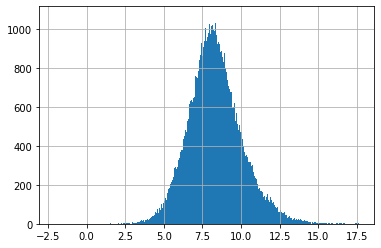

In [8]:
# Check intensity histogram for batch effect and noise tail.
np.log2(df.Intensity).hist(bins = 1000)


In [9]:

experiments_list = df.experiment_id.unique()
specie_list = df.specie.unique()

In [10]:
experiments_list

array(['005-Pedro', '006-Pedro', '003-Pedro', '004-Pedro', '007-Pedro',
       '002-Pedro'], dtype=object)

In [11]:
specie_list

array(['HUMAN', 'ECOLI', 'YEAS8'], dtype=object)

In [12]:
# Select the protein intensity with highest searchScore, i.e. lowest m_score, same as triqler does, but we put
# in -np.log10(m_score) as triqler search results.
def get_protein_intensity_df(df_exp):
    protein_array = []
    intensity_array = []
    for protein in df_exp.ProteinName.unique():
        intensity = df_exp[df_exp.ProteinName == protein].sort_values(by = "m_score", ascending = False).Intensity.iloc[0]
        protein_array.append(protein)
        intensity_array.append(float(intensity))
        
    df_prot = pd.DataFrame(np.array([protein_array, intensity_array]).T, columns = ["protein", "intensity"])
    if len(df_exp.experiment_id.unique()) == 1:
        df_prot["run"] = df_exp.experiment_id.unique()[0]
    else:
        print("Non-unique run id, this should not happen!")
    if len(df_exp.sample_id.unique()) == 1:
        df_prot["sample"] = df_exp.sample_id.unique()[0]
    else:
        print("Non-unique sample id, this should not happen!")
    df_prot["intensity"] = df_prot["intensity"].astype(float)
    return df_prot    

In [13]:
# Defining some functions for finding differential expressions for different species.
# Defining function for finding intersecting proteins between two samples.

def get_intersecting_protein(df_prot1, df_prot2):
    intersecting_proteins = pd.Series(list(set(df_prot1.protein).intersection(set(df_prot2.protein))))
    return len(intersecting_proteins)
    
def get_differentially_expressed_protein_ECOLI(df_prot1, df_prot2, treshold = 2.0):
    intersecting_proteins = pd.Series(list(set(df_prot1.protein).intersection(set(df_prot2.protein))))
    print(str(len(intersecting_proteins)) + " intersecting proteins.")
    
    fc_array = []
    protein_array = []
    for protein in intersecting_proteins:
        protA = np.log2(df_prot1[df_prot1.protein == protein].intensity).iloc[0]
        protB = np.log2(df_prot2[df_prot2.protein == protein].intensity).iloc[0]
        fc = protB - protA
        fc_array.append(fc)
        protein_array.append(protein)
    df_fc = pd.DataFrame(np.array([protein_array, fc_array]).T, columns = ["protein", "log2_fc"])
    df_fc["log2_fc"] = df_fc["log2_fc"].astype(float)
    return (df_fc["log2_fc"] > treshold).sum()

def get_differentially_expressed_protein_YEAST(df_prot1, df_prot2, treshold = -1.0):
    intersecting_proteins = pd.Series(list(set(df_prot1.protein).intersection(set(df_prot2.protein))))
    print(str(len(intersecting_proteins)) + " intersecting proteins.")
    
    fc_array = []
    protein_array = []
    for protein in intersecting_proteins:
        protA = np.log2(df_prot1[df_prot1.protein == protein].intensity).iloc[0]
        protB = np.log2(df_prot2[df_prot2.protein == protein].intensity).iloc[0]
        fc = protB - protA
        fc_array.append(fc)
        protein_array.append(protein)
    df_fc = pd.DataFrame(np.array([protein_array, fc_array]).T, columns = ["protein", "log2_fc"])
    df_fc["log2_fc"] = df_fc["log2_fc"].astype(float)
    return (df_fc["log2_fc"] < treshold).sum()


def get_differentially_expressed_protein_HUMAN(df_prot1, df_prot2, treshold = 0.5):
    intersecting_proteins = pd.Series(list(set(df_prot1.protein).intersection(set(df_prot2.protein))))
    print(str(len(intersecting_proteins)) + " intersecting proteins.")
    
    fc_array = []
    protein_array = []
    for protein in intersecting_proteins:
        protA = np.log2(df_prot1[df_prot1.protein == protein].intensity).iloc[0]
        protB = np.log2(df_prot2[df_prot2.protein == protein].intensity).iloc[0]
        fc = protB - protA
        fc_array.append(fc)
        protein_array.append(protein)
    df_fc = pd.DataFrame(np.array([protein_array, fc_array]).T, columns = ["protein", "log2_fc"])
    df_fc["log2_fc"] = df_fc["log2_fc"].astype(float)
    return (((df_fc["log2_fc"] > treshold).sum()) + ((df_fc["log2_fc"] < -treshold).sum()))

In [29]:

import time
#treshold = 2.0
#specie = "ECOLI"

def get_DE_df(df, specie, treshold):
    start = time.time()
    de_array = []
    intersecting_array = []
    for exp1 in experiments_list:
        de_column_array = []
        intersecting_column_array = []
        print("")
        print("A: " + exp1)
        for exp2 in experiments_list:

            df_exp1 = df[(df.experiment_id == exp1) & (df.specie == specie)]
            df_exp2 = df[(df.experiment_id == exp2) & (df.specie == specie)]

            df_prot1 = get_protein_intensity_df(df_exp1)
            df_prot2 = get_protein_intensity_df(df_exp2)

            intersecting_proteins = get_intersecting_protein(df_prot1, df_prot2)
            if specie == "ECOLI":
                de = get_differentially_expressed_protein_ECOLI(df_prot1, df_prot2, treshold = treshold)
            elif specie == "YEAS8":
                de = get_differentially_expressed_protein_YEAST(df_prot1, df_prot2, treshold = treshold)
            elif specie == "HUMAN":
                de = get_differentially_expressed_protein_HUMAN(df_prot1, df_prot2, treshold = treshold)

            intersecting_column_array.append(intersecting_proteins)
            de_column_array.append(de)
            print(time.time() - start, end = "")
            print("s")
            print("B: " + exp2, end = " : ")

        de_array.append(de_column_array)
        intersecting_array.append(intersecting_column_array)   

    exp_group_list = []
    for exp in experiments_list:
        group = df[df.experiment_id == exp].sample_id.unique()[0] 
        exp_sample = exp + "_group_" + group
        exp_group_list.append(exp_sample)

    end = time.time()
    print(end-start)

    df_de = pd.DataFrame(de_array, columns = [exp + "_log2(B)" for exp in exp_group_list], 
                         index = [exp + "_log2(A)" for exp in exp_group_list])
    return df_de

In [30]:
df_de_ECOLI = get_DE_df(df, specie = "ECOLI", treshold = 2)


A: 005-Pedro
1288 intersecting proteins.
4.023360967636108s
B: 005-Pedro : 947 intersecting proteins.
7.114363670349121s
B: 006-Pedro : 1219 intersecting proteins.
10.9523286819458s
B: 003-Pedro : 925 intersecting proteins.
13.934740781784058s
B: 004-Pedro : 1228 intersecting proteins.
17.758689403533936s
B: 007-Pedro : 944 intersecting proteins.
20.785205602645874s
B: 002-Pedro : 
A: 006-Pedro
947 intersecting proteins.
23.80911087989807s
B: 005-Pedro : 964 intersecting proteins.
26.355366468429565s
B: 006-Pedro : 944 intersecting proteins.
29.358729362487793s
B: 003-Pedro : 839 intersecting proteins.
31.76109480857849s
B: 004-Pedro : 948 intersecting proteins.
34.81345510482788s
B: 007-Pedro : 847 intersecting proteins.
37.238869428634644s
B: 002-Pedro : 
A: 003-Pedro
1219 intersecting proteins.
41.00436854362488s
B: 005-Pedro : 944 intersecting proteins.
43.996920585632324s
B: 006-Pedro : 1270 intersecting proteins.
47.762887477874756s
B: 003-Pedro : 924 intersecting proteins.
50.7

In [31]:
df_de_YEAST = get_DE_df(df, specie = "YEAS8", treshold = -1)


A: 005-Pedro
1401 intersecting proteins.
4.396606683731079s
B: 005-Pedro : 1363 intersecting proteins.
9.108211994171143s
B: 006-Pedro : 1258 intersecting proteins.
13.09600567817688s
B: 003-Pedro : 1366 intersecting proteins.
17.501834392547607s
B: 004-Pedro : 1288 intersecting proteins.
21.351354360580444s
B: 007-Pedro : 1356 intersecting proteins.
25.689265727996826s
B: 002-Pedro : 
A: 006-Pedro
1363 intersecting proteins.
30.086605548858643s
B: 005-Pedro : 1717 intersecting proteins.
35.428309202194214s
B: 006-Pedro : 1341 intersecting proteins.
40.07136678695679s
B: 003-Pedro : 1615 intersecting proteins.
45.32923460006714s
B: 004-Pedro : 1401 intersecting proteins.
50.085126876831055s
B: 007-Pedro : 1596 intersecting proteins.
55.6868531703949s
B: 002-Pedro : 
A: 003-Pedro
1258 intersecting proteins.
60.052454233169556s
B: 005-Pedro : 1341 intersecting proteins.
65.08089423179626s
B: 006-Pedro : 1373 intersecting proteins.
69.36115598678589s
B: 003-Pedro : 1338 intersecting prot

In [47]:
df_de_HUMAN = get_DE_df(df, specie = "HUMAN", treshold = 0.5)


A: 005-Pedro
2893 intersecting proteins.
10.990715980529785s
B: 005-Pedro : 2825 intersecting proteins.
22.084383726119995s
B: 006-Pedro : 2811 intersecting proteins.
32.69512963294983s
B: 003-Pedro : 2823 intersecting proteins.
43.50190472602844s
B: 004-Pedro : 2826 intersecting proteins.
54.26665377616882s
B: 007-Pedro : 2806 intersecting proteins.
65.41136193275452s
B: 002-Pedro : 
A: 006-Pedro
2825 intersecting proteins.
76.17648649215698s
B: 005-Pedro : 2911 intersecting proteins.
86.96463799476624s
B: 006-Pedro : 2807 intersecting proteins.
97.37719535827637s
B: 003-Pedro : 2841 intersecting proteins.
108.28251338005066s
B: 004-Pedro : 2831 intersecting proteins.
119.01819181442261s
B: 007-Pedro : 2823 intersecting proteins.
129.600604057312s
B: 002-Pedro : 
A: 003-Pedro
2811 intersecting proteins.
140.33947229385376s
B: 005-Pedro : 2807 intersecting proteins.
151.13101434707642s
B: 006-Pedro : 2895 intersecting proteins.
162.04955554008484s
B: 003-Pedro : 2831 intersecting prot

In [44]:
df_de_ECOLI.style.set_caption('Colormaps, with a caption.').background_gradient()

,005-Pedro_group_2_log2(B),006-Pedro_group_1_log2(B),003-Pedro_group_2_log2(B),004-Pedro_group_1_log2(B),007-Pedro_group_2_log2(B),002-Pedro_group_1_log2(B)
005-Pedro_group_2_log2(A),0,108,124,99,119,87
006-Pedro_group_1_log2(A),185,0,175,100,188,101
003-Pedro_group_2_log2(A),129,100,0,106,129,91
004-Pedro_group_1_log2(A),146,89,149,0,165,76
007-Pedro_group_2_log2(A),115,107,119,92,0,87
002-Pedro_group_1_log2(A),205,138,184,112,221,0


In [45]:
df_de_YEAST.style.set_caption('Colormaps, with a caption.').background_gradient()

,005-Pedro_group_2_log2(B),006-Pedro_group_1_log2(B),003-Pedro_group_2_log2(B),004-Pedro_group_1_log2(B),007-Pedro_group_2_log2(B),002-Pedro_group_1_log2(B)
005-Pedro_group_2_log2(A),0,228,266,242,271,272
006-Pedro_group_1_log2(A),526,0,534,303,479,366
003-Pedro_group_2_log2(A),264,237,0,245,265,282
004-Pedro_group_1_log2(A),509,285,522,0,463,334
007-Pedro_group_2_log2(A),274,227,277,244,0,286
002-Pedro_group_1_log2(A),403,253,403,254,371,0


In [48]:
df_de_HUMAN.style.set_caption('Colormaps, with a caption.').background_gradient()

,005-Pedro_group_2_log2(B),006-Pedro_group_1_log2(B),003-Pedro_group_2_log2(B),004-Pedro_group_1_log2(B),007-Pedro_group_2_log2(B),002-Pedro_group_1_log2(B)
005-Pedro_group_2_log2(A),0,1412,1237,1362,1225,1425
006-Pedro_group_1_log2(A),1412,0,1501,1231,1349,1407
003-Pedro_group_2_log2(A),1237,1501,0,1356,1339,1342
004-Pedro_group_1_log2(A),1362,1231,1356,0,1381,1256
007-Pedro_group_2_log2(A),1225,1349,1339,1381,0,1501
002-Pedro_group_1_log2(A),1425,1407,1342,1256,1501,0


# Triqler

In [51]:
os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")
from triqler_output_to_df import parse_triqler

os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/triqler_ecoli_fc2_full_tsv")

df = parse_triqler("proteins.tsv")
df = df[df.protein_id_posterior_error_prob < 0.05]
specie_mapper = lambda x : x.split("_")[-1]
df["specie"] = df.protein.map(specie_mapper)


In [53]:

def get_triqler_DE_fc(df, specie, treshold):
    df_rv = df[df.specie == specie].drop(['protein', 'peptides', 'q_value', 'posterior_error_prob',
           'num_peptides', 'protein_id_posterior_error_prob', 'log2_fold_change',
           'diff_exp_prob_2.0', "specie"], axis = 1 ).astype(float)
        
    def get_fc_DE_ECOLI(A, B, treshold = 2.0):
        return (np.log2(B / A) > treshold).sum()
    def get_fc_DE_YEAST(A, B, treshold = -1.0):
        return (np.log2(B / A) < treshold).sum()
    def get_fc_DE_HUMAN(A, B, treshold = 0.5):
        return ((np.log2(B / A) > treshold).sum() + 
                (np.log2(B / A) < -treshold).sum())
    
    de_array = []
    #start = time.time()
    for A in df_rv.columns:
        de_column_array = []
        #print("A: " + A)
    
        for B in df_rv.columns:
            #print("B: " + B)
            if specie == "HUMAN":
                de = get_fc_DE_HUMAN(df_rv[A],df_rv[B], treshold = treshold)
            elif specie == "YEAS8":
                de = get_fc_DE_YEAST(df_rv[A],df_rv[B], treshold = treshold)
            elif specie == "ECOLI":
                de = get_fc_DE_ECOLI(df_rv[A],df_rv[B], treshold = treshold)
            de_column_array.append(de)
        de_array.append(de_column_array)
        #print(time.time() - start)
            
    
    #end = time.time()
    #print(end-start)
    
    df_de = pd.DataFrame(de_array, columns = [exp + "_log2(B)" for exp in df_rv.columns], 
                         index = [exp + "_log2(A)" for exp in df_rv.columns])
    return df_de
    

In [54]:
triq_de_ECOLI = get_triqler_DE_fc(df, specie = "ECOLI", treshold = 2)
triq_de_YEAST = get_triqler_DE_fc(df, specie = "YEAS8", treshold = -1)
triq_de_HUMAN = get_triqler_DE_fc(df, specie = "HUMAN", treshold = 0.5)

In [55]:
triq_de_ECOLI.style.set_caption('Colormaps, with a caption.').background_gradient()

,1:002-Pedro_log2(B),1:004-Pedro_log2(B),1:006-Pedro_log2(B),2:003-Pedro_log2(B),2:005-Pedro_log2(B),2:007-Pedro_log2(B)
1:002-Pedro_log2(A),0,15,19,136,230,345
1:004-Pedro_log2(A),5,0,18,59,96,134
1:006-Pedro_log2(A),5,11,0,56,77,109
2:003-Pedro_log2(A),2,3,5,0,3,2
2:005-Pedro_log2(A),3,6,8,2,0,2
2:007-Pedro_log2(A),2,6,8,1,1,0


In [56]:
triq_de_YEAST.style.set_caption('Colormaps, with a caption.').background_gradient()

,1:002-Pedro_log2(B),1:004-Pedro_log2(B),1:006-Pedro_log2(B),2:003-Pedro_log2(B),2:005-Pedro_log2(B),2:007-Pedro_log2(B)
1:002-Pedro_log2(A),0,4,6,362,179,125
1:004-Pedro_log2(A),13,0,7,777,539,399
1:006-Pedro_log2(A),18,11,0,857,679,559
2:003-Pedro_log2(A),17,11,10,0,30,34
2:005-Pedro_log2(A),19,12,10,44,0,37
2:007-Pedro_log2(A),16,11,11,55,35,0


In [57]:
triq_de_HUMAN.style.set_caption('Colormaps, with a caption.').background_gradient()

,1:002-Pedro_log2(B),1:004-Pedro_log2(B),1:006-Pedro_log2(B),2:003-Pedro_log2(B),2:005-Pedro_log2(B),2:007-Pedro_log2(B)
1:002-Pedro_log2(A),0,101,172,123,171,212
1:004-Pedro_log2(A),101,0,89,115,120,124
1:006-Pedro_log2(A),172,89,0,198,137,127
2:003-Pedro_log2(A),123,115,198,0,102,156
2:005-Pedro_log2(A),171,120,137,102,0,86
2:007-Pedro_log2(A),212,124,127,156,86,0
